## InvestOps Tutorial - Long-Term Stock Forecasting

[Original repository on GitHub](https://github.com/Hvass-Labs/InvestOps-Tutorials)

Original author is [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

----

"*Doc, I'm from the future! I came here in a time-machine that you invented! Now I need your help to get back to the year 1985!*" - [Back to the Future](https://www.youtube.com/watch?v=SR5BfQ4rEqQ)

## Introduction

This tutorial shows how to use the InvestOps class `StockForecast` to forecast long-term stock returns. The method is described in the [paper](#refs) referenced below.

Briefly explained, if you can perfectly predict the future valuation ratio of a stock, such as its P/E or P/Sales ratio, and its future growth in Earnings or Sales Per Share, and its future Dividend Yield, then you can predict the future stock-return with complete accuracy, because the stock-return can be mathematically decomposed into these three individual components. To see this consider the trivial rewrite of the share-price using the P/Sales ratio:

$$
    Share Price = Sales Per Share \cdot \frac{Share Price}{Sales Per Share} = Sales Per Share \cdot P/Sales
$$

So a change in share-price from the current time-step $t$ to a future time-step $t+Years$ can be calculated from the change in the Sales Per Share and P/Sales ratio over this period:

$$
    \frac{Share Price_{t+Years}}{Share Price_t} = \frac{Sales Per Share_{t+Years}}{Sales Per Share_t} \cdot \frac{P/Sales_{t+Years}}{P/Sales_t}
$$

The annualized change in share-price is then calculated as follows:

$$
    Ann Price Change = \left( \frac{Sales Per Share_{t+Years}}{Sales Per Share_t} \cdot \frac{P/Sales_{t+Years}}{P/Sales_t} \right) ^ {1/Years} - 1
$$

Changes in share-prices and dividends are the only two sources of share-holder returns, and the dividends can be taken into account by multiplying the formula above with the future Dividend Yield, so as to obtain the so-called Total Return of the stock.

Because we cannot predict the future valuation ratio, growth-rate and dividend yield with complete accuracy, we instead use a whole range of our best guesses as input in the formula above, and we then get a whole range or distribution of possible stock-returns as output. We summarize this distribution using the mean and standard deviation.

We typically use the P/Sales ratio instead of e.g. the P/E or P/Book ratios, because the P/Sales ratio uses the Sales Per Share as its ratio-divisor, so it is usually much more stable than e.g. the P/E ratio which is also ill-defined if the Earnings Per Share is zero or negative.

For a general valuation ratio, the following formula calculates the mean annualized stock-return for an investment period of $Years$. So this formula gives the average of the forecasted future stock-returns, based on the current valuation ratio today:

$$
    E[ Ann Return ] = \frac{a}{Current Val Ratio ^ {1/Years}} - 1
$$

where the parameter $a$ is calculated from our guesses for the future annual growth-rate for e.g. the Sales Per Share, the future Dividend Yield, and the future valuation ratio such as the P/Sales ratio:

$$
    a = E \left[ (1 + Growth Rate) \cdot (1 + Div Yield) \cdot (Future Val Ratio) ^ {1/Years} \right]
$$

The standard deviation of the annualized stock-return is calculated quite similarly:

$$
    Std[ Ann Return ] = \frac{b}{Current Val Ratio ^ {1/Years}}
$$

where the parameter $b$ is again calculated from our guesses for the future growth-rate in e.g. Sales Per Share, the future Dividend Yield, and the future valuation ratios such as the P/Sales ratio:

$$
    b = Std \left[ (1 + Growth Rate) \cdot (1 + Div Yield) \cdot (Future Val Ratio) ^ {1/Years} \right]
$$

So we need to provide arrays with reasonable guesses for the future growth-rate in e.g. Sales Per Share, the future Dividend Yield, and the future valuation ratio such as the P/Sales ratio, and insert these guesses into the formulas above, in order to calculate the parameters $a$ and $b$, which can then be used to estimate the mean and std.dev. for the future annualized stock-returns. That is essentially just what the stock-forecasting model does.

The reason these formulas are only useful for long-term stock forecasting, is that e.g. the Sales Per Share is a constant in the short-term, so the short-term change in share-price cannot be decomposed into the change in Sales Per Share and P/Sales ratio.

The paper referenced below gives a much more detailed explanation with many real-world case-studies.

## References <a id="refs"></a>

- M.E.H. Pedersen, "*Long-Term Stock Forecasting*", 2020. ([PDF](https://ssrn.com/abstract=3750775)) ([Video](https://www.youtube.com/watch?v=L8OtWNCQAAs))

## Google Colab

In [1]:
# Check if this is running in Google Colab. Then we need to clone
# the GitHub repository to get extra Python modules and data-files.
if 'google.colab' in str(get_ipython()):
    # Clone the repo from GitHub to Google Colab's temporary drive.
    import os
    work_dir = "/content/InvestOps-Tutorials/"
    if not os.path.exists(work_dir):
        !git clone https://github.com/Hvass-Labs/InvestOps-Tutorials.git

    # Change dir so we can use the cloned files.
    os.chdir(work_dir)

    # Install all the required Python packages.
    !pip install -r requirements.txt

## Imports

In [2]:
%matplotlib inline

In [3]:
# Python packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# InvestOps.
import investops as iv
from investops.stock_forecast import StockForecast

In [5]:
# InvestOps Tutorials.
from data import StockData

In [6]:
# InvestOps version.
iv.__version__

'0.4.0'

## Random Number Generator

The forecasting model uses random sampling of the possible future valuation ratios, growth-rates, and dividend yields. This means the forecasting model can give slightly different results, each time you fit a new model with the same data. By seeding the Random Number Generator (RNG) with a number, the forecasting model should give the same result each time you run this Notebook.

In [7]:
# Random number generator.
# The seed makes the experiments repeatable.
rng = np.random.default_rng(seed=80085)

## Helper-Functions

In [8]:
def print_forecast(model, cur_val_ratio):
    """
    Use the given model to forecast the future stock-returns and
    print the mean and std.dev. for the return distribution.
    
    :param model: StockForecast object.
    :param cur_val_ratio: Float with current valuation ratio.
    """
    # Use the forecasting model to predict the future annualized return.
    # This gives a mean and std.dev. for the return distribution.
    forecast_mean, forecast_std = \
        model.forecast(cur_val_ratio=cur_val_ratio)

    # Print the results.
    print(f'Forecast Mean: {forecast_mean:.1%}')
    print(f'Forecast Std.: {forecast_std:.1%}')    

## Simple Example

This example is a small version of how you might want to use the stock-forecasting model, if you are not using historical data for the valuation ratios, growth-rates and dividend yield. Then you must supply the forecasting model with this data yourself, and you can specify whether the data is DEPENDENT in which case the three arrays must have the same length, or the data is INDEPENDENT in which case the three arrays can have different lengths because they will be sampled independently of each other.

In [9]:
# Current valuation ratio for today.
# This could be today's P/Sales or P/E ratio.
cur_val_ratio = 1.1

# Possible future Valuation Ratios.
# These could be e.g. P/Sales or P/E ratios.
val_ratio = [0.8, 1.0, 1.2]

# Possible future Growth-Rates.
# For example, a value of -0.053 means a Growth Rate of -5.3%
# NOTE: This must be consistent with the valuation ratio, so
# if you are using the P/Sales ratios then you must use the
# growth-rate for the Sales Per Share.
growth = [-0.1, 0.0, 0.2]

# Possible future Dividend Yields.
# For example, a value of 0.025 means a Dividend Yield of 2.5%
div_yield = [0.04, 0.02, 0.01]

# Probabilities for the different future outcomes.
# These should be between 0 and 1 and must sum to 1.
# In this example the probabilities are heavily skewed so the
# first case occurs with a very high probability of 0.7 (or 70%).
prob = [0.7, 0.2, 0.1]

In [10]:
# Create a forecasting model and fit it with the data above for
# the possible future values, which are set to be DEPENDENT here,
# so the three arrays with possible future outcomes will be sampled
# in the same order. We are interested in 3-year annualized returns.
model_dep = StockForecast(div_yield=div_yield, val_ratio=val_ratio,
                          growth=growth, dependent=True, years=3,
                          rng=rng, prob=prob)

In [11]:
# Create a forecasting model using the same data as above, but now
# the possible future values are set to be INDEPENDENT so the three
# arrays with possible future outcomes will be sampled independently
# of each other. We are still interested in 3-year annualized returns.
model_ind = StockForecast(div_yield=div_yield, val_ratio=val_ratio,
                          growth=growth, dependent=True, years=3,
                          rng=rng, prob_div_yield=prob,
                          prob_growth=prob, prob_val_ratio=prob)

We can now use the two forecasting models with the current valuation ratio, to estimate the future stock-returns. These are shown as the mean and standard deviations for the return-distributions.

The forecasts are very different for the DEPENDENT and INDEPENDENT models. This is a quite extreme example, because the arrays are very small with only 3 cases of possible future values for the valuation ratio, growth-rates, and dividend yields. And furthermore, the probabilities are heavily skewed towards the first case.

In practice you often don't see such a big difference between the DEPENDENT and INDEPENDENT forecasting models.

In [12]:
# Use forecasting model with DEPENDENT sampling of future values.
# Show the forecasted mean and std.dev. for the future return.
print_forecast(model=model_dep, cur_val_ratio=cur_val_ratio)

Forecast Mean: -8.8%
Forecast Std.: 12.6%


In [13]:
# Use forecasting model with INDEPENDENT sampling of future values.
# Show the forecasted mean and std.dev. for the future return.
print_forecast(model=model_ind, cur_val_ratio=cur_val_ratio)

Forecast Mean: 2.6%
Forecast Std.: 16.8%


We can also plot the forecasting model. The black solid line is the forecasted mean stock-return for different choices of the current valuation ratio. The two green regions show 1 standard deviation around the mean. The two red regions show 2 standard deviations around the mean. The vertical dashed blue line shows the current valuation ratio today. Note again that there is a big difference between the DEPENDENT and INDEPENDENT forecasting models, for the reasons explained above.

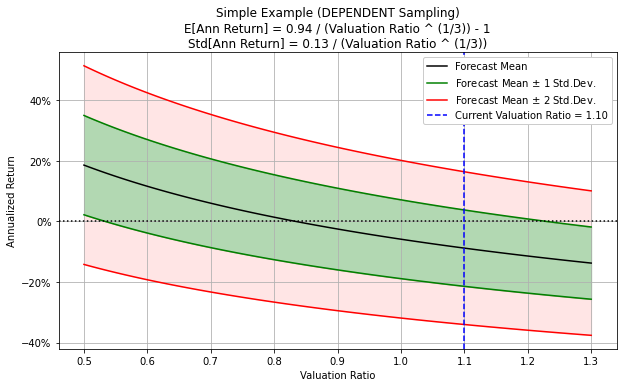

In [14]:
# Plot forecasting model with DEPENDENT sampling of future values.
title_dep = 'Simple Example (DEPENDENT Sampling)'
model_dep.plot(title=title_dep, cur_val_ratio=cur_val_ratio,
               min_val_ratio=0.5, max_val_ratio=1.3);

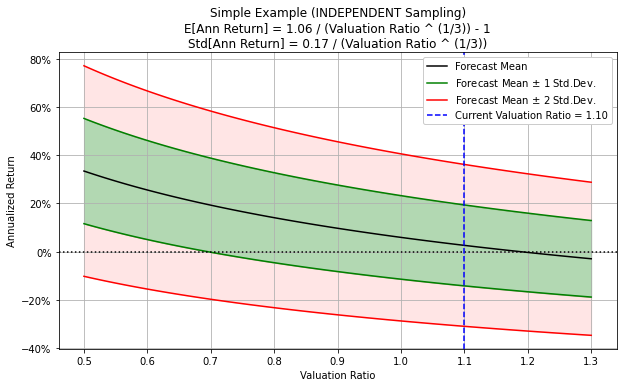

In [15]:
# Plot forecasting model with INDEPENDENT sampling of future values.
title_ind = 'Simple Example (INDEPENDENT Sampling)'
model_ind.plot(title=title_ind, cur_val_ratio=cur_val_ratio,
               min_val_ratio=0.5, max_val_ratio=1.3);

If we do not have any historical data for the stock-returns, then we can generate synthetic historical stock-returns. This first generates random valuation ratios in the given range, and then it uses the probability distribution of the forecasting model itself to generate the random stock-returns associated with those valuation ratios. This is shown in the next plot.

But as we will see further below, this looks very different from actual historical stock-returns. The colouring of the dots is not meaningful in this plot here, and will be explained further below where it is useful.

In [16]:
# Generate random historical valuation ratios and ann. returns.
hist_val_ratios, hist_ann_rets = \
    model_ind.random(min_val_ratio=0.5, max_val_ratio=1.5, num_samples=500)

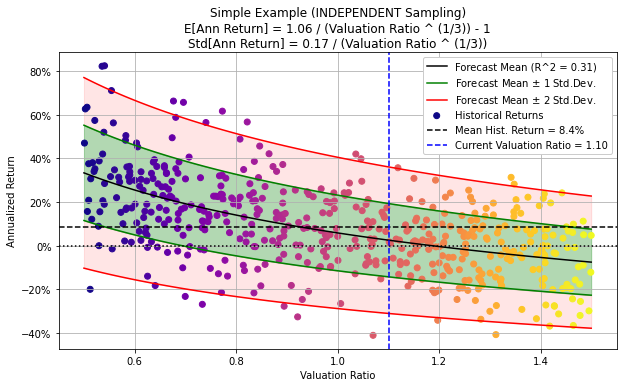

In [17]:
# Plot forecasting model with INDEPENDENT sampling of future values,
# and overlay the "synthetic" historical stock-returns.
model_ind.plot(title=title_ind, cur_val_ratio=cur_val_ratio,
               hist_val_ratios=hist_val_ratios,
               hist_ann_rets=hist_ann_rets,
               min_val_ratio=0.5, max_val_ratio=1.3);

## Case Study: Procter & Gamble (PG)

Let us now consider a real-world case-study for the Procter & Gamble company with stock-ticker PG. We have nearly 30 years of data for this company. It is a good example of the forecasting model having a very good fit to the historical data.

In [18]:
# Object for loading and processing the stock-data.
# This automatically loads CSV data-files from disk.
stock_PG = StockData(ticker='PG')

# Current P/Sales ratio for the PG stock in March 2022.
cur_val_ratio_PG = 4.4

Let us plot the basic financial data for the PG stock. The top-plot shows both the Share-Price and the Sales Per Share, with the y-axis being log-scaled. The second plot shows the P/Sales ratio, which is currently around its historical 30-year high. The third plot shows the annual growth-rates for the Sales Per Share. The final plot shows the Dividend Yield.

When using this historical data in the forecasting model, we essentially assume that the future valuation ratios, growth-rates and dividend yields will revert to the historical averages we see in these plots. This may or may not be a valid assumption!

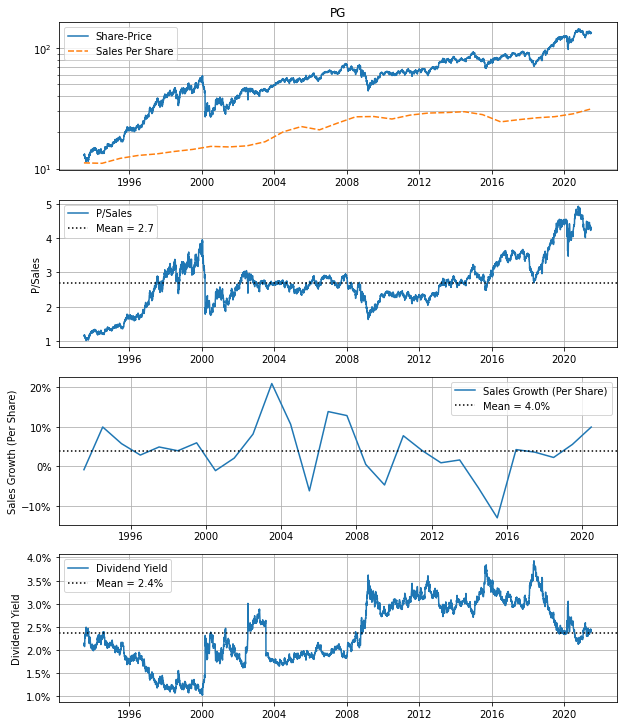

In [19]:
# Plot the basic financial data for the stock.
stock_PG.plot_basic_data(log_shareprice=True);

Now let us create and plot a forecasting model using the historical data for the PG stock. We first consider fairly short 1-3 year investment periods. The forecasting model uses INDEPENDENT sampling of the historical data, so the valuation ratios, growth-rates and dividend yields are all sampled independently from each other when calculating the parameters $a$ and $b$ in the forecasting model.

Each coloured dot in the plot shows a historical data-point for a given day, with the corresponding P/Sales ratio and the FUTURE average annualized stock-return from that day and going forward to all 1-3 year investment periods.

The colouring of the dots show the progression of time, so dots that have similar colours are close together in time. Note that the colours cannot generally be compared across different plots.

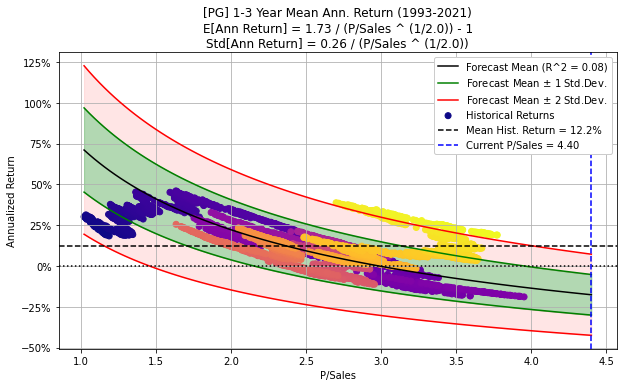

In [20]:
# Plot forecasting model for 1-3 year investment periods.
stock_PG.plot_forecast(min_years=1, max_years=3,
                       cur_val_ratio=cur_val_ratio_PG, rng=rng);

Now consider 3-5 year investment periods instead. This gives a much better fit between the forecasted mean and the historical stock-returns as measured by the $R^2$ value, with only one major cluster of outliers.

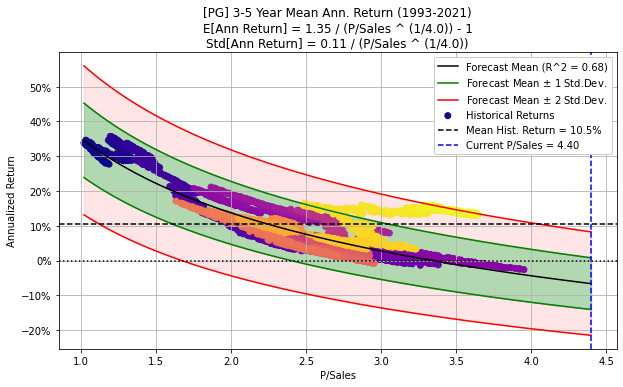

In [21]:
# Plot forecasting model for 3-5 year investment periods.
stock_PG.plot_forecast(min_years=3, max_years=5,
                       cur_val_ratio=cur_val_ratio_PG, rng=rng);

Now consider 6-10 year investment periods instead. This gives an exceptionally good fit between the forecasted mean and the historical stock-returns as measured by the $R^2$ value.

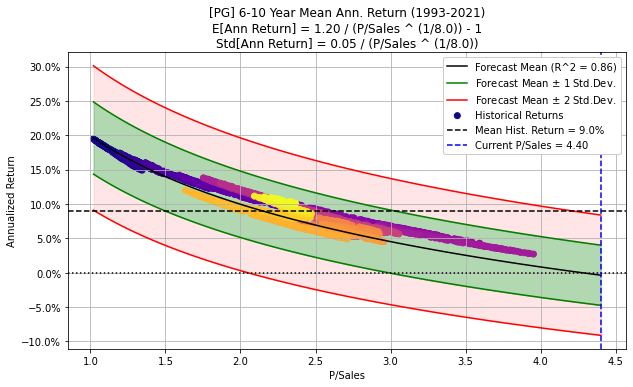

In [22]:
# Plot forecasting model for 6-10 year investment periods.
fig, model_PG = \
    stock_PG.plot_forecast(min_years=6, max_years=10,
                           cur_val_ratio=cur_val_ratio_PG, rng=rng);

We can now use the forecasting model that was fitted to the historical data, to forecast the future stock-returns from today and going 6-10 years into the future, using today's valuation ratio:

In [23]:
# Use forecasting model with the current valuation ratio.
print_forecast(model=model_PG, cur_val_ratio=cur_val_ratio_PG)

Forecast Mean: -0.4%
Forecast Std.: 4.4%


The forecasting model thinks there will be a small loss if we invest in the PG stock at the current valuation ratio, because it is historically high and the model assumes it will revert back to its historical mean, which will therefore cause a loss, but that will be made up by the future dividends and growth in Sales Per Share.

Whether this is an accurate forecast depends entirely on whether the future valuation ratios, growth-rates and dividend yields will be similar to their past values that were used in the forecasting model. If you believe the future values will be different from their historical values, then you should just use those other values instead in the forecasting model.

## Case Study: Wal-Mart (WMT)

Now we will consider another real-world case-study for the company Wal-Mart (WMT), which is an example of the forecasting model having a very bad fit to the historical data.

In [24]:
# Object for loading and processing the stock-data.
# This automatically loads CSV data-files from disk.
stock_WMT = StockData(ticker='WMT')

# Current P/Sales ratio for the WMT stock in March 2022.
cur_val_ratio_WMT = 0.69

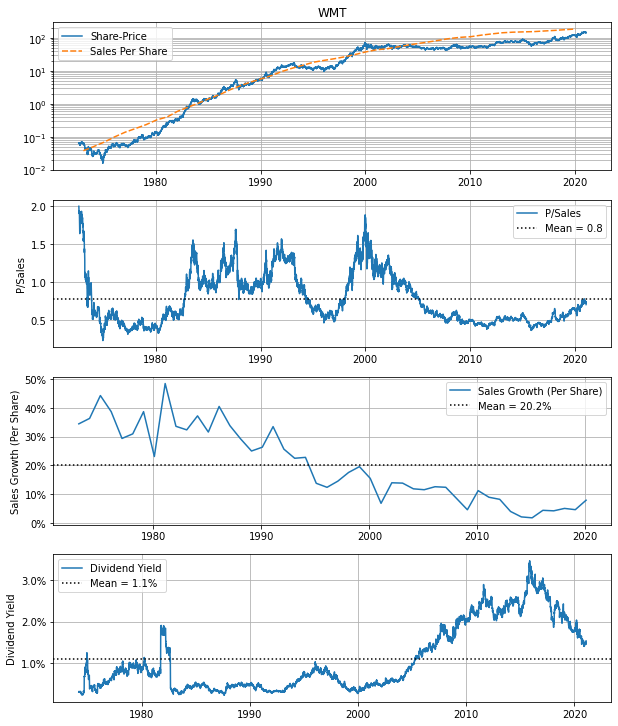

In [25]:
# Plot the basic financial data for the stock.
stock_WMT.plot_basic_data(log_shareprice=True);

The plot below shows the forecasting model for 6-8 year investment periods, overlaid with the historical data-points for the WMT stock. As can be seen, there is a very poor fit between the forecasted and actual historical stock-returns.

The reason is found in the plots above with the basic financial data, where the annual growth in Sales Per Share was very high around 40% in the beginning of the data-period, and then gradually decreased to around 5% towards the end of the data-period.

When using the entire data-period in the forecasting model, it uses the average growth-rate for Sales Per Share which was around 20%. But this is very inaccurate for the early part of the data-period where the growth-rate was closer to 40%, and the later part of the data-period where the growth-rate was closer to 5%. This shows up as the "levels" in the plot below of the forecasting model.

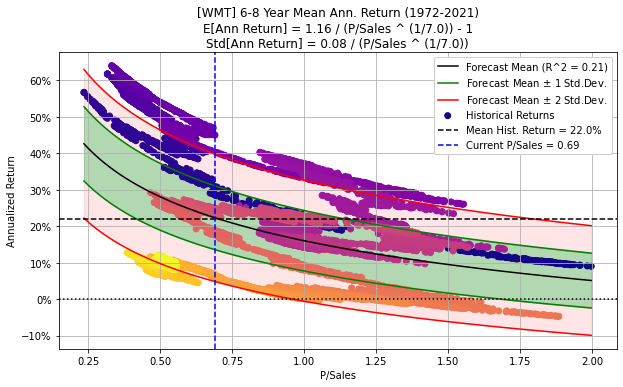

In [26]:
# Plot forecasting model for 6-8 year investment periods.
stock_WMT.plot_forecast(min_years=6, max_years=8,
                        cur_val_ratio=cur_val_ratio_WMT, rng=rng);

Instead of using the entire data-period between 1973-2022, let us just consider the last third of the data-period between 2005-2022. Now the forecasting model has a much better fit to the historical data as measured by the $R^2$ value.

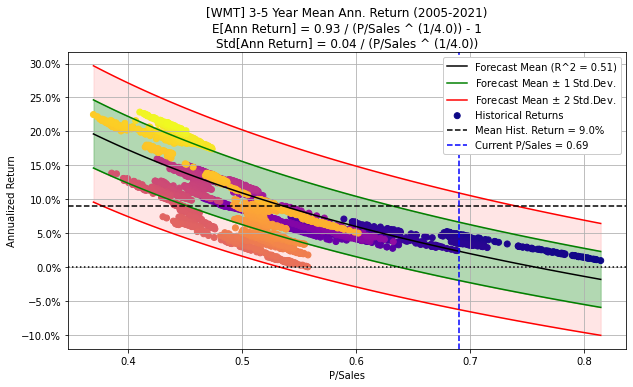

In [27]:
# Plot forecasting model for 3-5 year investment periods.
# This only uses the historical data from year 2005 onwards.
fig, model_WMT = \
    stock_WMT.plot_forecast(min_years=3, max_years=5,
                            cur_val_ratio=cur_val_ratio_WMT, rng=rng,
                            start_date='2005');

Using the current valuation ratio from the time of this writing in March 2022, in the forecasting model from the plot above, that was fitted to the historical financial data between 2005-2022, gives the following estimate for the mean and std.dev. of the future 3-5 year annualized return on the WMT stock:

In [28]:
# Use forecasting model with the current valuation ratio.
print_forecast(model=model_WMT, cur_val_ratio=cur_val_ratio_WMT)

Forecast Mean: 2.3%
Forecast Std.: 4.3%


## Conclusion

It is important to remember that the forecasting model is mathematically correct, so if you input the correct future valuation ratio, growth-rate and dividend yield, then the model will give the correct future stock-return as output.

We obviously don't know the correct values, but we can sometimes give a reasonable range of guesses, and then the forecasting model outputs a range of estimates for the future stock-return, in the form of the mean and standard deviation of the return-distribution.

Whether the forecasting model has a good fit to the historical data is almost irrelevant, if the future valuation ratio, growth-rates and dividend yields are not going to be similar to the past. So the final advice is that you should always consider whether your assumptions about the future values are reasonable, regardless of what the historical values were.

## License (MIT)

This is published under the [MIT License](https://github.com/Hvass-Labs/InvestOps-Tutorials/blob/main/LICENSE) which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/Hvass-Labs/InvestOps-Tutorials).